In [1]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers

import jax.numpy as jnp
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [104]:
pip install polygon-api-client

In [106]:
import polygon_interface
import yahoo_interface

In [107]:
df = yahoo_interface.get_all_features('AAPL', '2000-01-01', '2025-03-10')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


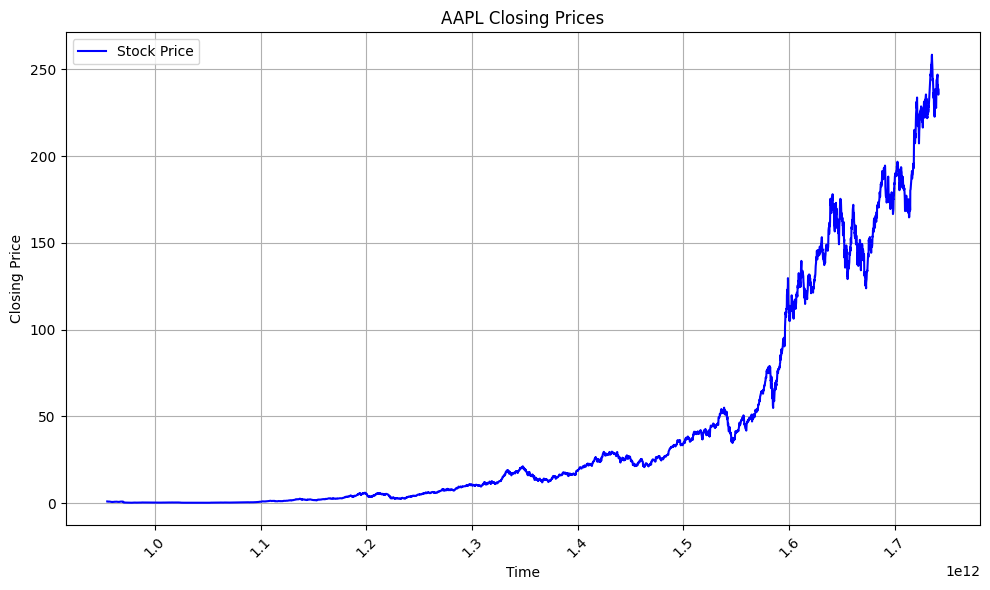

In [35]:
# Plotting the closing prices
plt.figure(figsize=(10, 6))
plt.plot(df['Timestamp'], df['Close'], color = 'blue', label = 'Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.title('AAPL Closing Prices')
plt.tight_layout()
plt.show()

# **Data Processing**


In [36]:
# function for creating sequences to feed into model
def create_training_sequences(data, window_size):
    """
      Returns a list of windows in data of length window_size
          and a list containing corresponding to the data value immediately proceeding a window

      :param data: a numpy array of shape (n, 1), e.g. closing_prices
      :param window_size: length of window
    """

    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i: i + window_size, 0])    # closing prices in last (seq_length)-days
        y.append(data[i + window_size, 0])       # closing price in day after the x-sequence
    return np.array(X), np.array(y)

In [68]:
y_train.shape

(4327,)

In [80]:
chunk_size = 365
window_size = 60
X_train = np.empty((0,60), dtype = 'float64')
X_val = np.empty((0,60), dtype = 'float64')
y_train = np.empty((0), dtype = 'float64')
y_val = np.empty((0), dtype = 'float64')

for i in range(len(df)//chunk_size):
  # get chunk of dataframe
  df_chunk = df[i*chunk_size: min((i+1)*chunk_size, len(df))]

  # Put closing prices into numpy array
  closing_prices = df_chunk['Close'].values.reshape(-1, 1)

  # Normalize the data between [0,1]
  scaler = MinMaxScaler(feature_range = (0, 1))
  scaled_data = scaler.fit_transform(closing_prices)

  # Define training and validation sizes
  train_size = int(len(df_chunk) * 0.7)
  val_size = len(df_chunk) - train_size

  # Split into training and validation sets
  train, val = scaled_data[: train_size, :], scaled_data[train_size:, :]

  # Using the data sets, create sequences to feed into model
  X, y = create_training_sequences(train, window_size)
  X_train = np.concatenate((X_train, X))
  y_train = np.concatenate((y_train, y))

  X, y = create_training_sequences(val, window_size)
  X_val = np.concatenate((X_val, X))
  y_val = np.concatenate((y_val, y))


# **Model Construction and Training**

In [81]:
model = keras.Sequential([
    layers.LSTM(32, return_sequences = True, input_shape = (X_train.shape[1], 1)),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [82]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 60, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,761 (53.75 KB)

 Trainable params: 13,761 (53.75 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = 50, validation_data=(X_val, y_val))


Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0608 - val_loss: 0.0045
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0123 - val_loss: 0.0061
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0101 - val_loss: 0.0031
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0088 - val_loss: 0.0028
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0076 - val_loss: 0.0034
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0067 - val_loss: 0.0044
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0065 - val_loss: 0.0020
Epoch 9/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 10/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 11/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 12/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 

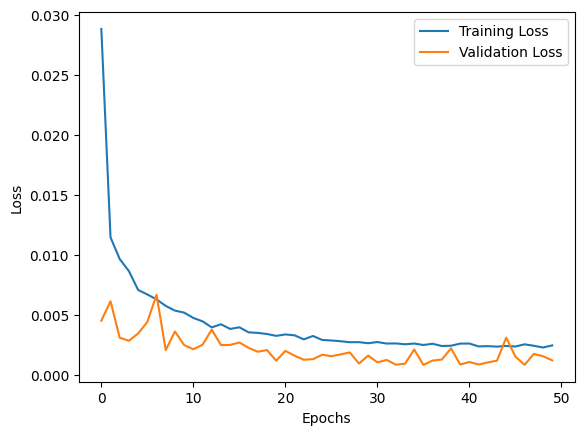

In [84]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Performance on Unsmoothed Data

In [109]:
# modified version of create_training_sequences. Only outputs X array, not y array
def create_sequences(data, window_size):
    """
      Returns a list of windows in data of length window_size
          and a list containing corresponding to the data value immediately proceeding a window

      :param data: a numpy array of shape (n, 1), e.g. closing_prices
      :param window_size: length of window
    """

    X = []
    for i in range(len(data) - window_size + 1):
        X.append(data[i: i + window_size, 0])    # closing prices in last (seq_length)-days
    return np.array(X)

In [115]:
# reading data
df = yahoo_interface.get_all_features('AAPL', '2023-01-01', '2025-01-01', smoothing = False)
closing_prices = df['Close'].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(closing_prices)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [116]:
# formatting data to be fed into model
window_size = 60
X_full = create_sequences(scaled_data, window_size)

# getting predictions
full_predict = model.predict(X_full)
full_predict = scaler.inverse_transform(full_predict)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


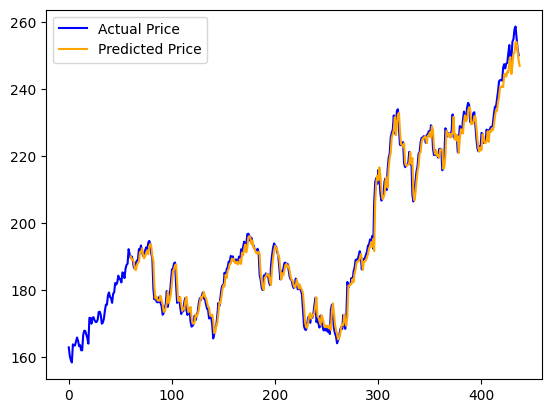

In [117]:
# Formatting data into arrays to be plotted
known_plot = np.empty((closing_prices.shape[0] + 1, 1))
known_plot[:, :] = np.nan
known_plot[:closing_prices.shape[0], :] = closing_prices

prediction_plot = np.empty((closing_prices.shape[0] + 1, 1))
prediction_plot[:, :] = np.nan
prediction_plot[window_size: closing_prices.shape[0] + 1, :] = full_predict

# Plot actaul vs predictions
plt.plot(known_plot, color = 'blue', label = 'Actual Price')
plt.plot(prediction_plot, color = 'orange', label = 'Predicted Price')
plt.legend()
plt.show()

#**Performance on Different Stocks**

In [126]:
yahoo_interface.get_all_features('RNMBY', '2023-01-01', '2025-01-01', smoothing = False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Timestamp,Date,Close,Volume,Open,High,Low,Vwap,MACD Value,Signal,RSI Value,Williams %R,%K,%D,%J
40,1680757200000,2023-04-06,55.142578,4600,54.487521,55.480327,54.453454,55.025453,1.643087,1.769875,71.970291,-57.068378,35.546113,61.863342,-17.088345
41,1681102800000,2023-04-10,55.266193,7000,55.480329,55.480329,55.066661,55.271061,1.453195,1.706539,64.253190,-70.461523,13.322974,36.890126,-33.811330
42,1681189200000,2023-04-11,55.421925,9900,56.093531,56.142197,55.090989,55.551704,1.300282,1.625287,57.886254,-68.000033,15.623268,21.497452,3.874900
43,1681275600000,2023-04-12,56.053627,44900,56.103266,56.453669,55.879398,56.128898,1.216052,1.543440,60.229020,-69.639820,21.385063,16.777101,30.600985
44,1681362000000,2023-04-13,57.242073,4300,57.144737,57.251805,57.005552,57.166477,1.231007,1.480954,62.077291,-47.091362,33.881223,23.629851,54.383968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,1735016400000,2024-12-24,129.582001,3600,128.000000,130.000000,128.000000,129.194000,1.822152,2.851701,36.745958,-73.124102,48.976315,39.456224,68.016495
473,1735189200000,2024-12-26,130.460007,8600,129.589996,130.470001,128.800003,129.910004,1.770908,2.635542,35.007303,-64.402784,58.019533,49.886094,74.286410
474,1735275600000,2024-12-27,128.559998,16600,129.100006,129.119995,128.490005,128.723333,1.559010,2.420236,34.670395,-61.002795,54.905561,53.967136,56.782410
475,1735534800000,2024-12-30,127.589996,9900,127.220001,128.281998,127.160004,127.677333,1.297848,2.195758,45.531264,-75.223619,49.238822,54.054639,39.607190


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


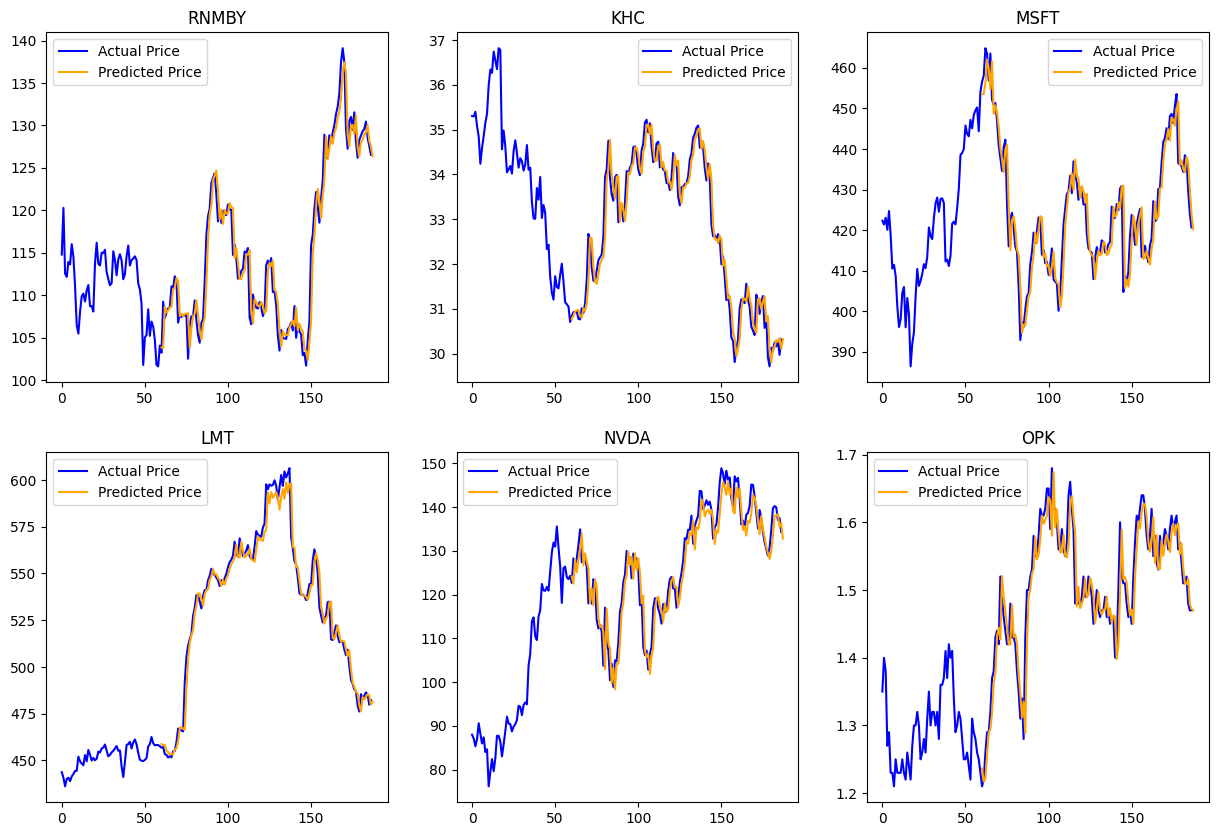

In [128]:
tickers = ['RNMBY', 'KHC', 'MSFT', 'LMT', 'NVDA', 'OPK']

plt.figure(figsize = (15,10))
for i in range(6):
  # reading data
  df = yahoo_interface.get_all_features(f'{tickers[i]}', '2024-01-01', '2025-01-01', smoothing = False)
  closing_prices = df['Close'].values.reshape(-1, 1)
  scaled_data = scaler.fit_transform(closing_prices)

  # formatting data to be fed into model
  window_size = 60
  X_full = create_sequences(scaled_data, window_size)

  # getting predictions
  full_predict = model.predict(X_full)
  full_predict = scaler.inverse_transform(full_predict)

  # Plotting real vs predicted prices
  known_plot = np.empty((closing_prices.shape[0] + 1, 1))
  known_plot[:, :] = np.nan
  known_plot[:closing_prices.shape[0], :] = closing_prices

  prediction_plot = np.empty((closing_prices.shape[0] + 1, 1))
  prediction_plot[:, :] = np.nan
  prediction_plot[window_size: closing_prices.shape[0] + 1, :] = full_predict

  # set up subplots
  plt.subplot(2,3,i+1)
  plt.title(f'{tickers[i]}')
  plt.plot(known_plot, color = 'blue', label = 'Actual Price')
  plt.plot(prediction_plot, color = 'orange', label = 'Predicted Price')
  plt.legend()

plt.show()

# **Applying the Model for Forecasting**

In [150]:
# reading data
df_full = yahoo_interface.get_all_features('AAPL', '2005-01-01', '2006-01-01', smoothing = False)
df_predictor = df_full[:60]
closing_prices = df_predictor['Close'].values.reshape(-1, 1)

# normalizing
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(closing_prices)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [151]:
# obtaining one prediction
window_size = 60
X_one = create_sequences(scaled_data, window_size)
one_predict = model.predict(X_one)
one_predict = scaler.inverse_transform(one_predict)
one_predict[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


array([1.1051916], dtype=float32)

In [152]:
import math

def clipped_normal(mean=0, std = 0.33, size=1):
    values = np.random.normal(mean, std, size)
    return np.clip(values, -1, 1)

# Example usage
random_value = clipped_normal()
print(random_value)

[-0.38844322]


In [153]:
# define forecast window size
days_forward = 60

# initialize array to store future values
forecast_arr = scaled_data

# get predictions
for i in range(days_forward):
  seq = create_sequences(forecast_arr[-60:], window_size)
  one_predict = model.predict(seq, verbose = 0)
  one_predict[0][0] = max(min(one_predict[0][0]*(1 + 0.33 * clipped_normal()), 1), -1)
  forecast_arr = np.concatenate((forecast_arr, one_predict))

forecast_arr = scaler.inverse_transform(forecast_arr)

<ipython-input-153-23ded45bf1e2>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  one_predict[0][0] = max(min(one_predict[0][0]*(1 + 0.33 * clipped_normal()), 1), -1)


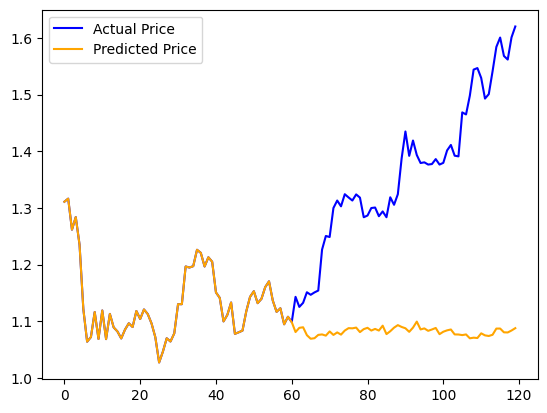

In [155]:
# Plotting real vs predicted prices
known_plot = np.empty((scaled_data.shape[0] + days_forward, 1))
known_plot[:, :] = np.nan
known_plot[:, :] = df_full['Close'][:scaled_data.shape[0] + days_forward].values.reshape(-1,1)

prediction_plot = np.empty((closing_prices.shape[0] + days_forward, 1))
prediction_plot[:, :] = np.nan
prediction_plot[: window_size + days_forward, :] = forecast_arr

# plot baseline and predictions
plt.plot(known_plot, color = 'blue', label = 'Actual Price')
plt.plot(prediction_plot, color = 'orange', label = 'Predicted Price')
plt.legend()
plt.show()